# <font color='red'> Description du projet </font>

## <font color='blue'>Présentation du problème </font>

L’objectif de ce projet est d’estimer **les temps de réponse et de mobilisation** de la Brigade des Pompiers de Londres. La brigade des pompiers de Londres est le service d'incendie et de sauvetage le plus actif du Royaume-Uni  et l'une des plus grandes organisations de lutte contre l'incendie et de sauvetage au monde.

Le premier jeu de données fourni contient les détails de chaque incident traité depuis janvier 2009. Des informations sont fournies sur la date et le lieu de l'incident ainsi que sur le type d'incident traité. Il est composé de deux fichiers

*   LFB Incident data from 2009 - 2017.xlsx
*   LFB Incident data from 2018 onwards.csv

Le second fichier peut-être récupéré à l'aide du lien : 'https://data.london.gov.uk/download/london-fire-brigade-incident-records/f5066d66-c7a3-415f-9629-026fbda61822/LFB%20Incident%20data%20from%202018%20onwards.csv.xlsx' pour avoir la dernière version du fichier. En effet, les données sont mises à jour tous les mois. Il faut compter au moins 7 minutes pour la lecture des données.

<br>

Le second jeu de données contient les détails de chaque camion de pompiers envoyé sur les lieux d'un incident depuis janvier 2009. Des informations sont fournies sur l'appareil mobilisé, son lieu de déploiement et les heures d'arrivée sur les lieux de l'incident. Il est composé de trois fichiers

*   LFB Mobilisation data from January 2009 - 2014.xlsx
*   LFB Mobilisation data from 2015 - 2020.xlsx
*   LFB Mobilisation data from January 2009 - 2014.xlsx

Le dernier fichier peut-être récupéré à l'aide du lien : 'https://data.london.gov.uk/download/london-fire-brigade-mobilisation-records/3ff29fb5-3935-41b2-89f1-38571059237e/LFB%20Mobilisation%20data%202021%20-%202024.xlsx' pour avoir la dernière version du fichier (mise à jour mensuelle). Il faut compter environ 17 minutes pour la lecture des données.

## <font color='blue'> Etapes précédentes </font>

*   1 - Exploration des données : premières analyses, concaténation des différents fichiers puis jointure des 2 types de données (incident / mobilisation)
*   2 - Data visualisation.ipynb : visualisation des données, étude de la variable à prédire (temps de réponse total) en fonction des variables explicatives, création d'un jeu de données pour la modélisation
*   5 - Preprocessing final : création des jeux de données pour la modélisation faite dans ce notebook



*Nota Bene* : Les notebooks numérotés 3 et 4 ont été conservés pour montrer un premier travail de modélisation qui a été abandonné par la suite (voir détails ci-dessous)


## <font color='blue'>Etapes dans ce notebook </font>

Dans ce notebook, nous avons modélisé la variable continue `TotalResponseTime_BC`. Nous avons testé des modèles linéaires (avec pénalisation ou non) et des modèles de classification.

Pour évaluer nos modèles (et les comparer) nous utilisons :
- le coefficient de détermination (R²) indique quelle fraction de la variance totale de la réponse est expliquée par le modèle. Son calcul est basé sur la somme des écarts carrés résiduels et totaux.
- la racine de l'erreur quadratique (ou RMSE). Contrairement au R², qui ne s'applique qu'aux modèles de régression linéaire, le RMSE est une métrique d'évaluation universelle qui nous permet de comparer les performances de prédiction de différents types de modèles.
- le graphique des valeurs observées versus prédites pour vérifier la qualité prédictive du modèle
- le graphique des résidus standardisés pour vérifier qu'il suivent une loi normale centrée réduite (distribution aléatoire des résidus autour de l'axe des abscisses avec des valeurs comprises majoritairement entre 0 et 4)

# <font color='red'>1) Préparation de l'environement de travail </font>

## <font color='blue'>Installation des modules </font>

In [ ]:
#!pip install matplotlib
#!pip install Seaborn
#!pip install openpyxl
#!pip install scipy
#!pip install geopandas
#!pip install scikit-learn
#!pip install statsmodels
#!pip install folium
#!pip install plotly
#!pip install --upgrade seaborn
#!pip install jupyter
#!pip install nbformat
!pip install lightgbm
!pip install xgboost
#!pip optuna

## <font color='blue'>Importation des bibliothèques </font>

In [ ]:
import pandas as pd  #Pour les dataframe
import numpy as np #Pour le calcul numérique
import datetime as dt # Pour le calcul sur les dates

## Libraries pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # graphique 3D
import plotly.express as px  #graphique 3D dynamique
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as offline

## Libraries pour statistiques
# régression linéaire
import statsmodels.api as sm
from statsmodels.formula.api import ols
# tests statistiques
from scipy.stats import shapiro , kstest # tests de sur la normalité de la distributin
from scipy.stats import bartlett # tests sur les variances
from scipy.stats import kruskal #  comparaison des médianes
from scipy.stats import spearmanr
from scipy.stats import loguniform, uniform
from scipy import stats # notamment pour boxplot
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error, accuracy_score

# Libraries divers
from copy import deepcopy  # gestion des copies

# Pour la séparation du jeu de données
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, LogisticRegression

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBClassifier
# import optuna


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




## <font color='blue'>Liaison avec le drive (pour travailler sur GoogleColab) </font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# <font color='red'>2) Données pour la modélisation </font>

## <font color='blue'>2.a) Chargement </font>


Chargement des données depuis GoogleColab

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Complete/Train_Dataset.csv', low_memory=False)
validation = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Complete/Validation_Dataset.csv', low_memory=False)

train_reduit = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Reduit2/Train_Dataset.csv', low_memory=False)
validation_reduit = pd.read_csv('/content/gdrive/My Drive/1_Rendu/FinalDatasets/Reduit2/Validation_Dataset.csv', low_memory=False)

Chargement des données depuis un emplacement en local

In [ ]:
train = pd.read_csv('../Data/Datapreprocessing/Complete/Train_Dataset.csv', low_memory=False)
validation = pd.read_csv('../Data/Datapreprocessing/Complete/Validation_Dataset.csv', low_memory=False)

train_reduit = pd.read_csv('../Data/Datapreprocessing/Reduit2/Train_Dataset.csv', low_memory=False)
validation_reduit = pd.read_csv('../Data/Datapreprocessing/Reduit2/Validation_Dataset.csv', low_memory=False)

## <font color='blue'>2.b) Sélection des variables </font>

In [ ]:
# X : variable explicative du modele --> on supprime IncidentNumber et les 4 variables à prédire
# y : on teste des modèles de regression, la variable à prédire est donc TotalResponseTime_BC
X_train = train.drop(columns=['IncidentNumber','ResponseTimeCategory', 'ResponseTimeCategory2', 'ResponseTimeBinary', 'TotalResponseTime_BC'])
y_train = train[['TotalResponseTime_BC']]

X_val = validation.drop(columns=['IncidentNumber','ResponseTimeCategory', 'ResponseTimeCategory2', 'ResponseTimeBinary', 'TotalResponseTime_BC'])
y_val = validation[['TotalResponseTime_BC']]


# même principe sur le jeux de données réduit (pour la recherche d'hyperparamètres)
X_train_r = train_reduit.drop(columns=['IncidentNumber','ResponseTimeCategory', 'ResponseTimeCategory2', 'ResponseTimeBinary', 'TotalResponseTime_BC'])
y_train_r = train_reduit[['TotalResponseTime_BC']]

X_val_r = validation_reduit.drop(columns=['IncidentNumber','ResponseTimeCategory', 'ResponseTimeCategory2', 'ResponseTimeBinary', 'TotalResponseTime_BC'])
y_val_r = validation_reduit[['TotalResponseTime_BC']]


# <font color='red'> 3) Méthodes
 </font>







Dans la suite de ce notebook, nous utilisons les méthodes définies ici

In [ ]:
### evaluation du modèle
# cette méthode calcul les différentes métriques permettant l'évaluation du modèle
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    max_err = max_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}")
    print(f"MSE (Validation): {mse:.4f}")
    print(f"RMSE (Validation): {rmse:.4f}")
    print(f"MAE (Validation): {mae:.4f}")
    print(f"MedAE (Validation): {medae:.4f}")
    print(f"Max Error (Validation): {max_err:.4f}")
    print(f"R² (Validation): {r2:.4f}")


In [ ]:
### graphique pred vs obs
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, label='Prédictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Référence')
    plt.title(f"Prédictions versus observations - {model_name}")
    plt.xlabel("Observations")
    plt.ylabel("Prédictions")
    plt.legend()
    plt.show()


In [ ]:
### graphique residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6));
    plt.hist(residuals, bins=20, alpha=0.7, color='blue', edgecolor='black');
    plt.axvline(0, color='red', linestyle='--');
    plt.title(f"Distribution des résidus - {model_name}");
    plt.xlabel("Résidus");
    plt.ylabel("Fréquence");
    plt.show();

In [ ]:
def plot_residuals2(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    res_norm = (residuals-residuals.mean())/residuals.std()
    plt.figure(figsize=(8, 6));
    plt.scatter(y_true, res_norm, alpha=0.7, label='Prédictions');
    plt.plot([y_true.min(), y_true.max()], [0, 0], 'r--');
    plt.title(f"Distribution des résidus standardisés - {model_name}");
    plt.ylabel("Résidus");
    plt.xlabel("Observations");
    plt.show();

In [ ]:
### estimation des paramètres, prédiction et calcul des métriques d'évaluation
def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    y_train = y_train.to_numpy().ravel() if isinstance(y_train, pd.DataFrame) else y_train
    y_val = y_val.to_numpy().ravel() if isinstance(y_val, pd.DataFrame) else y_val
    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de validation
    y_pred_val = model.predict(X_val)

    # Évaluation sur l'ensemble de validation
    evaluate_model(y_val, y_pred_val, model_name)

    return y_pred_val

In [ ]:
def find_best_params_and_predict(model, param_distributions, X_train, y_train, X_val, y_val, model_name):
    """
    Effectue une recherche des meilleurs paramètres pour un modèle donné avec RandomizedSearchCV, et retourne les prédictions.
    """
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=20,               # Nombre d'itérations de recherche aléatoire
        scoring='neg_mean_squared_error',  # Use an appropriate regression metric
        cv=3,                    # Nombre de plis pour la validation croisée
        n_jobs=-1,               # Utilisation de tous les cœurs disponibles
        verbose=1,               # Affiche les logs de progression
        random_state=42          # Pour garantir la reproductibilité
    )

    # Exécute la recherche
    randomized_search.fit(X_train, y_train)

    # Meilleurs paramètres et score
    print(f"\n{model_name} - Best Parameters: {randomized_search.best_params_}")
    print(f"{model_name} - Best Cross-Validation Score: {randomized_search.best_score_:.4f}")

    # Meilleur modèle entraîné
    best_model = randomized_search.best_estimator_

    # Prédictions sur l'ensemble de validation
    y_pred = best_model.predict(X_val)

    # Évaluation
    evaluate_model(y_val, y_pred, model_name)

    return y_pred, randomized_search.best_params_

# <font color='red'> 4) Modèles linéaires
 </font>

## <font color='blue'>4.a) Régression linéaire </font>

Nous avons d'abord essayé le modèle le plus simple existant : la régression linéaire. Nous avons pu fitter le modèle à l'ensemble des données.

In [ ]:
# statistiques descriptives sur y_train et y_val
display(y_train.describe())
display(y_val.describe())

,TotalResponseTime_BC
count,726399.000000
mean,27.860041
std,5.676146
min,0.816058
25%,24.456794
50%,27.581997
75%,30.973010
max,54.217048


,TotalResponseTime_BC
count,155657.000000
mean,27.848223
std,5.690639
min,0.816058
25%,24.456794
50%,27.581997
75%,30.973010
max,54.217048


Le coefficient de détermination est de 0.25. Les résultats sont similaires par cross-validation. Nous utilisons cette métrique pour comparer les différents modèles linéaires testés. Cette valeur est mauvaise.

In [ ]:
# Créer une instance du modèle de régression linéaire
lr = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
lr.fit(X_train, y_train)
y_pred_LR = lr.predict(X_val)

# Calculer les métriques d'évaluation
evaluate_model(y_val, y_pred_LR, "LinearRegression")



LinearRegression
MSE (Validation): 24.4096
RMSE (Validation): 4.9406
MAE (Validation): 3.5248
MedAE (Validation): 2.6224
Max Error (Validation): 36.6620
R² (Validation): 0.2462


In [ ]:
cross_val_score(lr,X_train,y_train, cv=5).mean()

0.24338343044087143

Les graphiques des prédictions versus observation et des résidus confirment que le modèle ne prédit pas correctement les données.

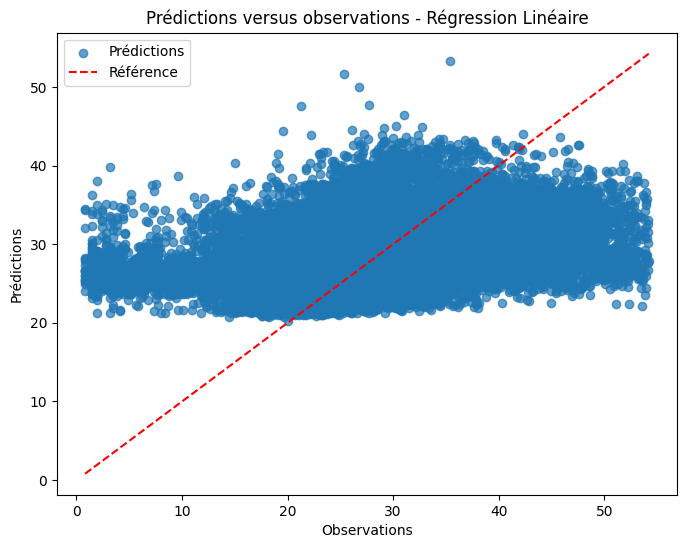

In [ ]:
plot_results(y_val, y_pred_LR, "Régression Linéaire");

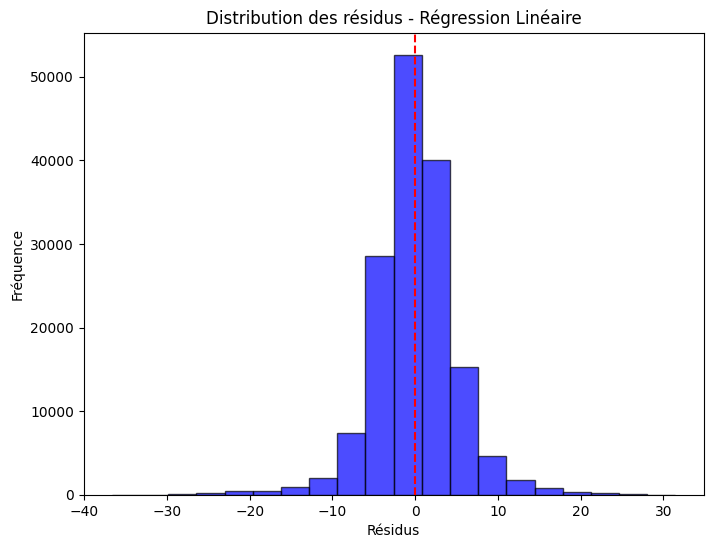

In [ ]:
plot_residuals(y_val, y_pred_LR, "Régression Linéaire");

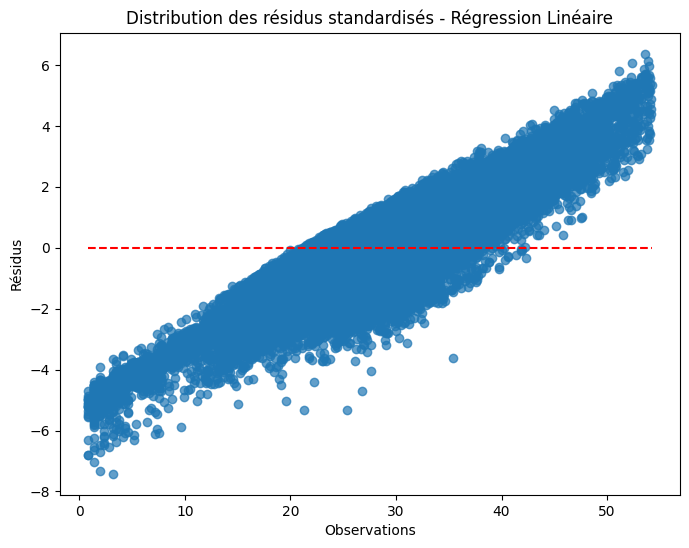

In [ ]:
plot_residuals2(y_val, y_pred_LR, "Régression Linéaire");

Nous avons sélectionné les 10 variables explicatives les plus significatives pour tester si la réduction du nombre de variables améliorait la prédiction. Ce n'est pas le cas.

***Nota Bene*** : il est intéressant de constater que parmi les 10 variables explicatives les plus significatives il y a la distance, la densité de casernes par arrondissement (`ratioStd`) et les 4 "tops" géographiques (`inner`, `Bor_inc_rep`, `Bor_resp_rep` et `Stat_resp_rep`).

In [ ]:
sk=SelectKBest(f_regression, k=10)
sk.fit(X=X_train, y=y_train)

X_train.columns[sk.get_support()]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Index(['inner', 'Bor_inc_rep', 'Bor_resp_rep', 'Stat_resp_rep',
       'PropCat_Outdoor', 'Borough_E09000017', 'Borough_E09000020',
       'Borough_E09000022', 'distStd', 'ratioStd'],
      dtype='object')

In [ ]:
# Créer une instance du modèle de régression linéaire
lr = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
lr.fit(X_train[['inner', 'Bor_inc_rep', 'Bor_resp_rep', 'Stat_resp_rep',
       'PropCat_Outdoor', 'Borough_E09000017', 'Borough_E09000020',
       'Borough_E09000022', 'distStd', 'ratioStd']], y_train)
y_pred_LR = lr.predict(X_val[['inner', 'Bor_inc_rep', 'Bor_resp_rep', 'Stat_resp_rep',
       'PropCat_Outdoor', 'Borough_E09000017', 'Borough_E09000020',
       'Borough_E09000022', 'distStd', 'ratioStd']])

# Calculer les métriques d'évaluation
evaluate_model(y_val, y_pred_LR, "LinearRegression")


LinearRegression
MSE (Validation): 24.8264
RMSE (Validation): 4.9826
MAE (Validation): 3.5606
MedAE (Validation): 2.6507
Max Error (Validation): 36.0932
R² (Validation): 0.2334


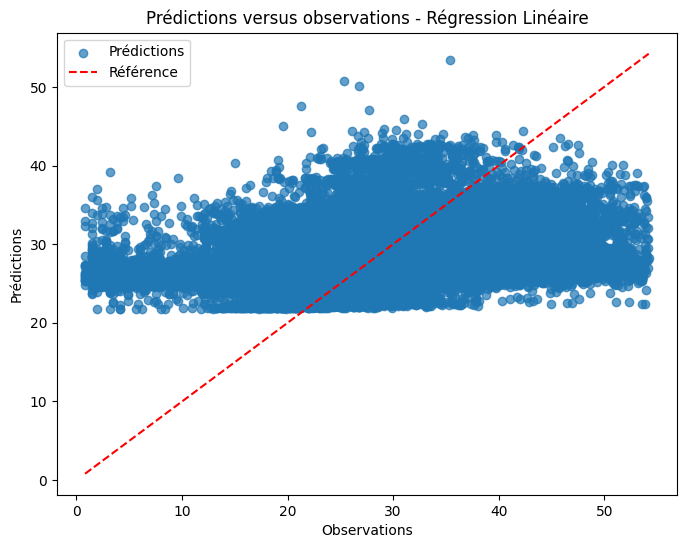

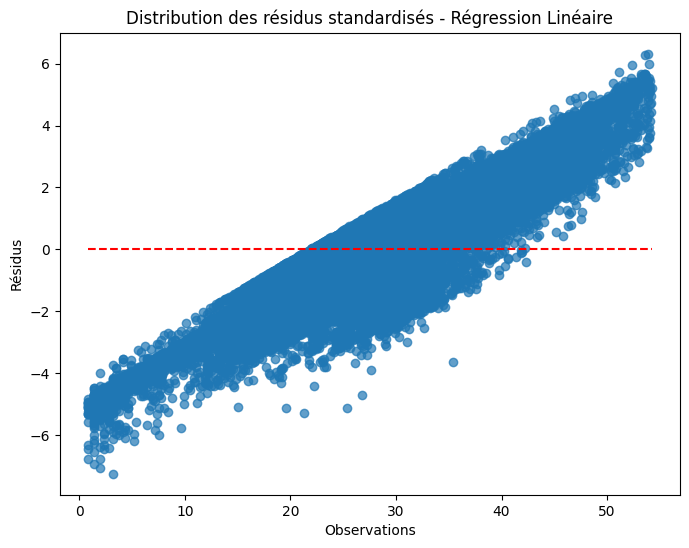

In [ ]:
plot_results(y_val, y_pred_LR, "Régression Linéaire");
plot_residuals2(y_val, y_pred_LR, "Régression Linéaire");

**Le modèle linéaire n'est pas adapté à notre jeu de données.**

## <font color='blue'>4.b) Régression linéaire avec pénalités </font>

### Première estimation

Nous avons modélisé nos données avec 3 modèles linéaires pénalisés : le modèle Ridge, Lasso et Elastic Net. Nous avons d'abord fixé les hyperparamètres à des valeurs arbitraires. On constate que la valeur de R² est similaire à celle de la régression linéaire. On ne voit pas d'amélioration sur le graphique des prédictions versus observations

In [ ]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
y_pred_ridge = train_and_evaluate_model(ridge_model, "Régression Ridge", X_train, y_train, X_val, y_val)

# Lasso Regression
lasso_model = Lasso(alpha=0.01)
y_pred_lasso = train_and_evaluate_model(lasso_model, "Régression Lasso", X_train, y_train, X_val, y_val)

# ElasticNet Regression
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
y_pred_elasticnet = train_and_evaluate_model(elasticnet_model, "Régression ElasticNet", X_train, y_train, X_val, y_val)


Régression Ridge
MSE (Validation): 24.4096
RMSE (Validation): 4.9406
MAE (Validation): 3.5248
MedAE (Validation): 2.6224
Max Error (Validation): 36.6619
R² (Validation): 0.2462

Régression Lasso
MSE (Validation): 24.4835
RMSE (Validation): 4.9481
MAE (Validation): 3.5277
MedAE (Validation): 2.6213
Max Error (Validation): 36.2482
R² (Validation): 0.2439

Régression ElasticNet
MSE (Validation): 25.3155
RMSE (Validation): 5.0315
MAE (Validation): 3.5868
MedAE (Validation): 2.6455
Max Error (Validation): 35.2631
R² (Validation): 0.2183


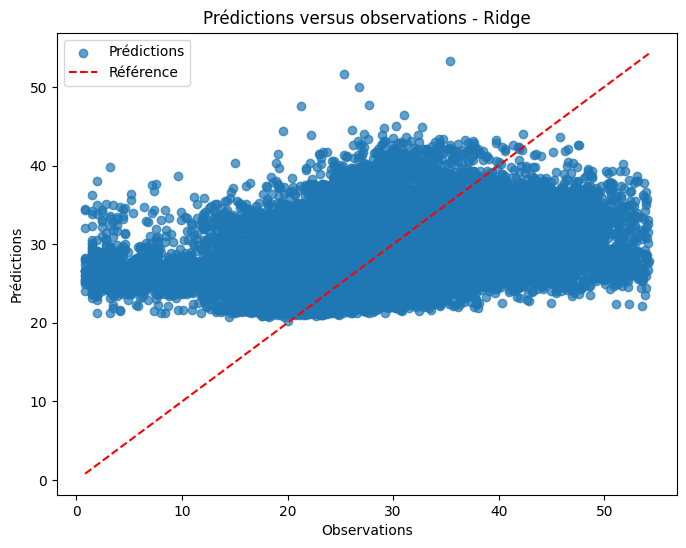

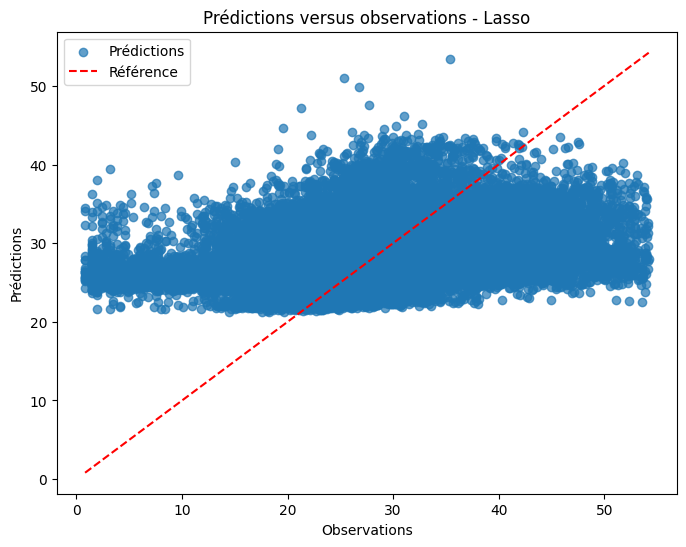

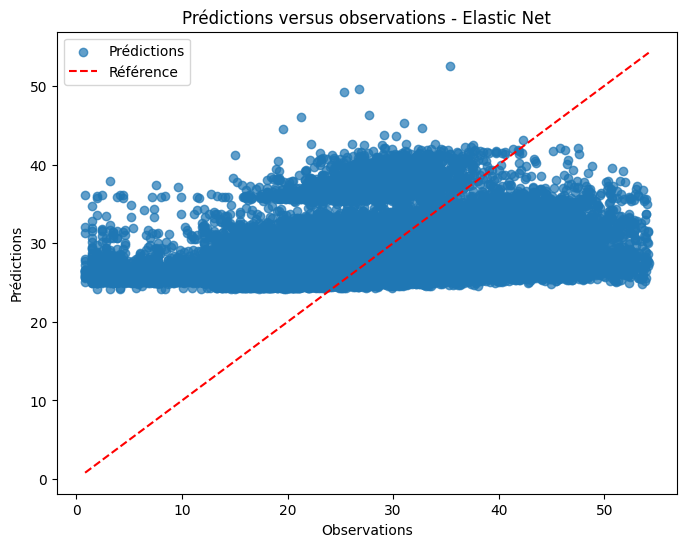

In [ ]:
plot_results(y_val, y_pred_ridge, "Ridge");
plot_results(y_val, y_pred_lasso, "Lasso");
plot_results(y_val, y_pred_elasticnet, "Elastic Net");

### Recherche des hyper paramètres - Ridge

Nous avons utilisé la méthode `RandomizedSearchCV` afin de rechercher la meilleure valeur de l'hyper paramètre `alpha` utilisé pour la pénalisation de Ridge. Nous avons utilisé la RMSE comme critère d'évaluation : la "meilleure" valeur de `alpha` correspond à celle pour laquelle la RMSE du modèle est la plus faible.

***Nota Bene*** : Contrairement à la méthode `GridSearchCV`, toutes les valeurs de paramètres fournies en entrée ne vont pas être testées via la méthode `RandomizedSearchCV`. L'argument `n_iter` indique le nombre d'ensemble de paramètres qui va être testé. Cela permet de parcourir un ensemble plus important d'hyper paramètres.

In [ ]:

# Définir les hyperparamètres pour RandomizedSearchCV
param_distributions = {
    'alpha': loguniform(0.001, 100)  # Échelle logarithmique pour une exploration efficace
}

# Configuration de RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=Ridge(),
    param_distributions=param_distributions,
    n_iter=50,  # Nombre d'itérations pour la recherche aléatoire (test de 50 valeurs de param_distributions)
    cv=KFold(n_splits=5, shuffle=True, random_state=42),  # Validation croisée à 5 folds
    scoring='neg_mean_squared_error',  # Critère d'évaluation, valeur la plus faible de RMSE
    random_state=42,  # Pour reproductibilité
    n_jobs=-1  # Utilisation de tous les cœurs disponibles
)

# Lancer la recherche des meilleurs hyperparamètres
random_search.fit(X_train, y_train)  # Utilisez ravel() si y_train est une colonne 2D

# Meilleurs hyperparamètres trouvés
best_ridge = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Meilleur modèle Ridge: {best_params}")

# Évaluer le meilleur modèle sur les données de validation
y_pred_best_ridge = best_ridge.predict(X_val)

# Afficher les métriques d'évaluation
evaluate_model(y_val, y_pred_best_ridge, "Ridge Regression Optimisée")


Meilleur modèle Ridge: {'alpha': 8.43101393208247}

Ridge Regression Optimisée
MSE (Validation): 24.4096
RMSE (Validation): 4.9406
MAE (Validation): 3.5248
MedAE (Validation): 2.6224
Max Error (Validation): 36.6617
R² (Validation): 0.2462


Malgré l'optimisation de l'hyper paramètre, l'estimation de R² est similaire et les prédictions du modèle sont toujours de mauvaise qualité.

In [ ]:
# Ridge Regression
ridge_model = Ridge(alpha=8.43)
y_pred_ridge = train_and_evaluate_model(ridge_model, "Régression Ridge", X_train, y_train, X_val, y_val)


Régression Ridge
MSE (Validation): 24.4096
RMSE (Validation): 4.9406
MAE (Validation): 3.5248
MedAE (Validation): 2.6224
Max Error (Validation): 36.6617
R² (Validation): 0.2462


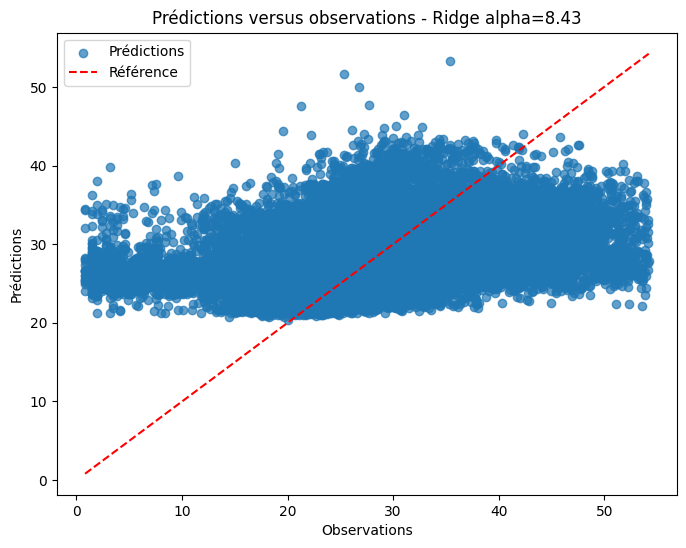

In [ ]:
plot_results(y_val, y_pred_ridge, "Ridge alpha=8.43");

### Recherche des hyper paramètres - Lasso et Elastic Net

Nous avons aussi recherché les meilleurs hyperparamètres pour les modèles de Lasso et Elastic Net. Malgré l'optimisation des hyper paramètres, l'estimation de R² est similaire et les prédictions du modèle sont toujours de mauvaise qualité.

In [ ]:

# Distributions des hyperparamètres pour ElasticNet
param_distributions_elasticnet = {
    'alpha': np.logspace(-3, 2, 100),  # Grille logarithmique pour alpha
    'l1_ratio': uniform(0.1, 0.9)  # Distribution uniforme entre 0.1 et 1
}

# ElasticNet
elasticnet = ElasticNet(max_iter=10000)

# RandomizedSearchCV pour ElasticNet
random_search_elasticnet = RandomizedSearchCV(
    estimator=elasticnet,
    param_distributions=param_distributions_elasticnet,
    n_iter=10,  # Nombre d'échantillons aléatoires
    scoring='neg_mean_squared_error',
    cv=5,  # Validation croisée
    verbose=1,
    random_state=42
)

# LassoCV ajuste automatiquement l'alpha
lasso = LassoCV(cv=5, max_iter=10000)

# Ajuster les modèles sur les données d'entraînement
random_search_elasticnet.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Affichage des résultats
print("Meilleurs paramètres ElasticNet :", random_search_elasticnet.best_params_)
print("Meilleur alpha LassoCV :", lasso.alpha_)

# Évaluer les modèles sur le jeu de validation
y_pred_elasticnet = random_search_elasticnet.predict(X_val)
y_pred_lasso = lasso.predict(X_val)

# Assurez-vous que y_val est un vecteur unidimensionnel
y_val = np.ravel(y_val)
evaluate_model(y_val, y_pred_elasticnet, "ElasticNet")
evaluate_model(y_val, y_pred_lasso, "LassoCV")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Meilleurs paramètres ElasticNet : {'alpha': 0.0012618568830660211, 'l1_ratio': 0.1185260448662222}
Meilleur alpha LassoCV : 0.002772323372539432

ElasticNet
MSE (Validation): 24.4148
RMSE (Validation): 4.9411
MAE (Validation): 3.5245
MedAE (Validation): 2.6214
Max Error (Validation): 36.6278
R² (Validation): 0.2461

LassoCV
MSE (Validation): 24.4221
RMSE (Validation): 4.9419
MAE (Validation): 3.5249
MedAE (Validation): 2.6195
Max Error (Validation): 36.5513
R² (Validation): 0.2458


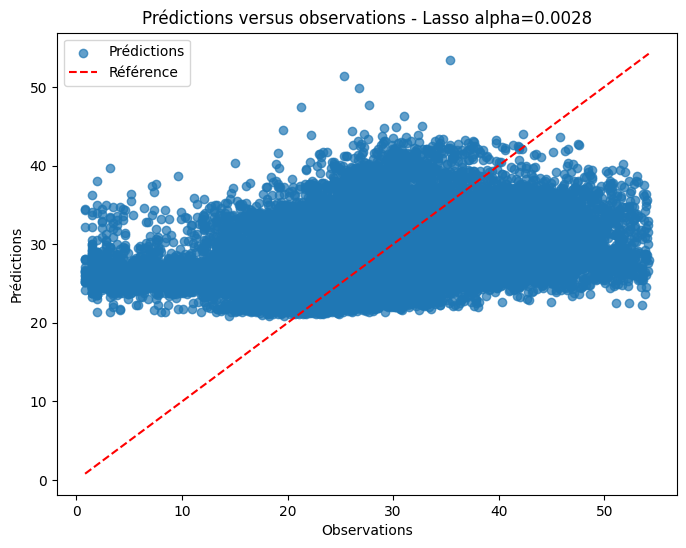

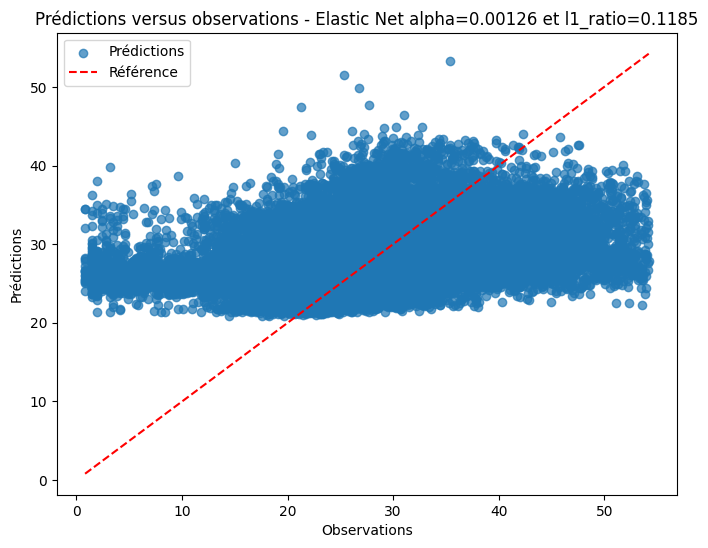

In [ ]:
plot_results(y_val, y_pred_lasso, "Lasso alpha=0.0028");
plot_results(y_val, y_pred_elasticnet, "Elastic Net alpha=0.00126 et l1_ratio=0.1185");

# <font color='red'> 5) Régresseurs non linéaires
 </font>


La régression linéaire n'est pas adaptée à nos données. Nous avons donc testé d'autres formes de régression issues des algorithmes tels que les arbres de décision, forêts aléatoires, SVM ou KNN. Lorsqu'on utilise ces régresseurs, où  la variable continue est catégorisée en autant de valeurs possibles que de “feuilles”. La feuille est alors une valeur numérique (plutôt qu’une catégorie) et représente la valeur moyenne pour les valeurs de variables explicatives associée à la feuille.

Initialement, ces méthodes ont été développées pour des variables catégorielles avec de nombreuses catégories ou des variables continues avec des valeurs dans l’ensemble N et non R.

*Source*
</br>
https://www.stat.cmu.edu/~cshalizi/350-2006/lecture-10.pdf
</br>
https://www.sciencedirect.com/topics/computer-science/regression-tree
</br>
https://builtin.com/data-science/regression-tree



## <font color='blue'>5.a) Decision Tree Regressor </font>

L'algorithme du régresseur via l'algorithme d'arbre de décision divise les données en minimisant l'erreur quadratique (MSE). Nous avons uniquement fixé le `random_state`, utilisant les autres paramètres par défaut. La profondeur de l'arbre n'est donc pas fixé et une "feuille" peut représenter une seule des valeurs observée.

***Nota Bene*** : comme il ne s'agit pas d'une regression linéaire, nous n'étudions pas la valeur de R² mais les valeurs des erreurs.

In [ ]:
model_DT = DecisionTreeRegressor(random_state=42)
model_name = "DecisionTreeRegressor"
# Entraîner et évaluer le modèle
y_pred_DTR= train_and_evaluate_model(model_DT, model_name, X_train, y_train, X_val, y_val)


DecisionTreeRegressor
MSE (Validation): 31.5848
RMSE (Validation): 5.6200
MAE (Validation): 3.7802
MedAE (Validation): 2.4805
Max Error (Validation): 51.4766
R² (Validation): 0.0247


L'erreur quadratique (MSE) et sa racine carré (RMSE) sont similaires à celles obtenues via les modèles de régression linéaire. Le graphique des prédictions versus observations est très légèrement amélioré : il n'y a plus de tendance visible. La prédiction du modèle reste mauvaise et il y a toujours une tendance très marquée au niveau des résidus.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



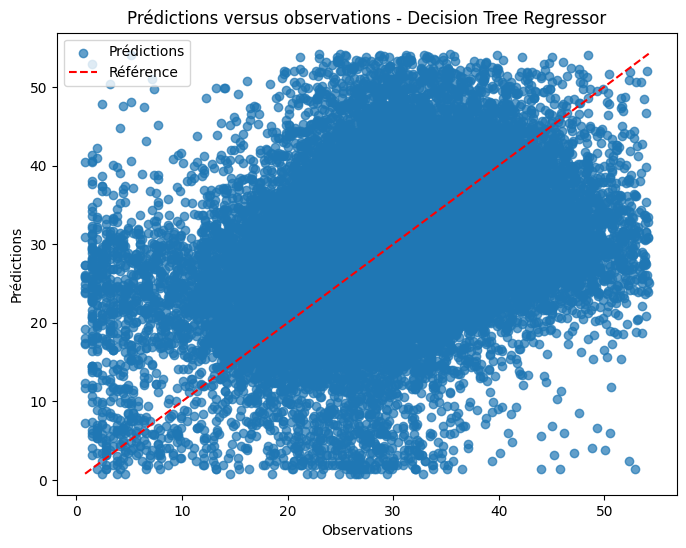

In [ ]:
plot_results(y_val, y_pred_DTR, "Decision Tree Regressor");

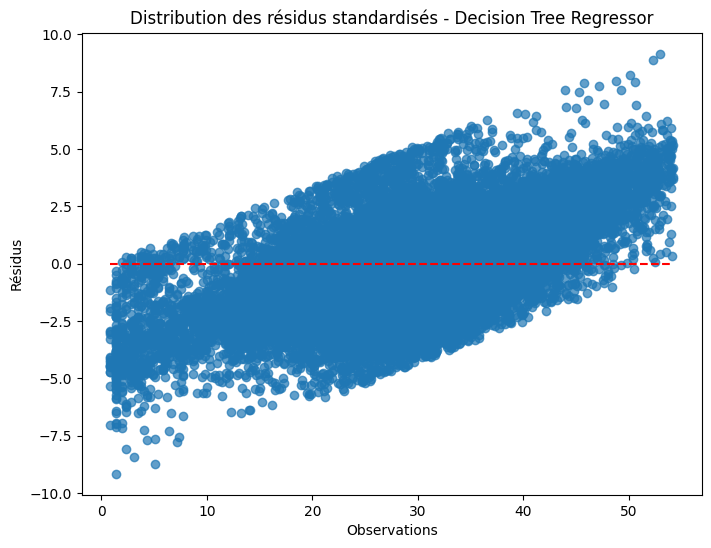

In [ ]:
# nota bene : pour que la méthode fonctionne, il faut modifier le format de y_pred_DTR
# print(y_pred_DTR.shape)
# print(np.reshape(y_pred_DTR,(y_pred_DTR.shape[0],1)).shape)

plot_residuals2(y_val, np.reshape(y_pred_DTR,(y_pred_DTR.shape[0],1)), "Decision Tree Regressor");

Il est intéressant de noter que la distance est la première variable explicative apparaissant dans l'arbre.

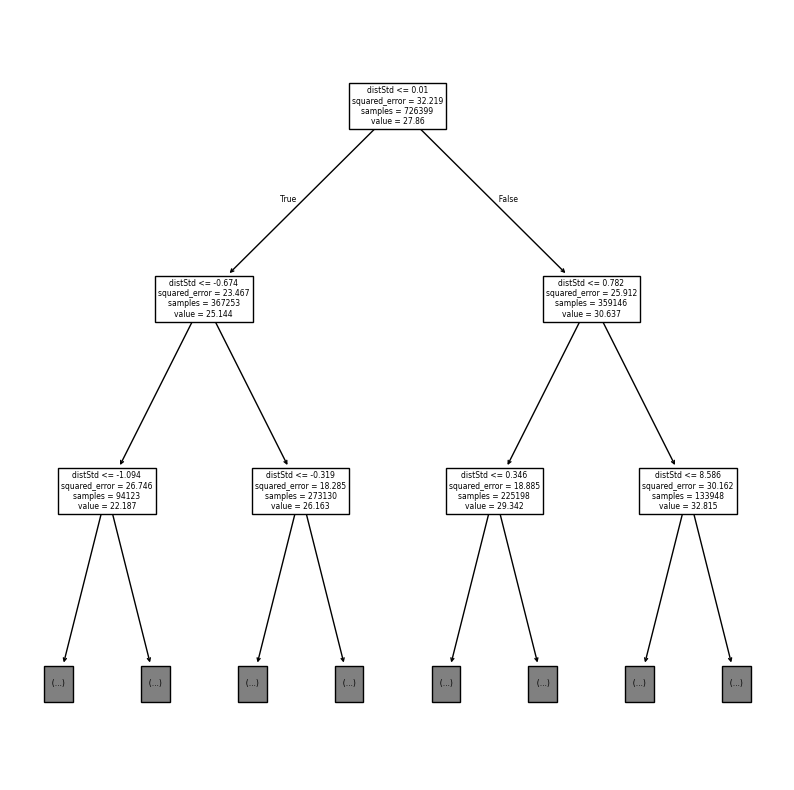

In [ ]:
plt.figure(figsize=(10,10))
plot_tree(model, feature_names=X_train.columns, max_depth=2);

La distance est de loin la variable présentant le plus d'importance dans le modèle, suivi par la densité de casernes (`ratioStd`) puis la plage horaire 11-17 (`H1117`).

In [ ]:
feat_imp = pd.DataFrame({'importance': model_DT.feature_importances_}, index=model_DT.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,0.797284
ratioStd,0.028248
H1117,0.021986
Bor_inc_rep,0.011772
PropCat_Road Vehicle,0.009560
PropCat_Dwelling,0.009460
H26,0.008428
PropCat_Non Residential,0.007686
PropCat_Outdoor Structure,0.006789
Stat_resp_rep,0.005890


## <font color='blue'>3.b) Random Forest Regressor </font>

### Première estimation

Comme pour le regresseur "*Decision Tree*", nous avons utilisé les paramètres par défaut pour l'algorithme de forêt aléatoire :
- Le nombre d'arbre est fixé à 100
- la construction des arbres se base sur la minimisation de la MSE
- la profondeur des arbres n'est donc pas fixée
- une "feuille" peut représenter une seule des valeurs observée

In [ ]:
del model, model_name
model = RandomForestRegressor(random_state=42)
model_name = "Random Forest Regressor"
# Entraîner et évaluer le modèle
y_pred_RFR=train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)




Random Forest Regressor
MSE (Validation): 20.8306
RMSE (Validation): 4.5641
MAE (Validation): 3.0962
MedAE (Validation): 2.1264
Max Error (Validation): 45.0669
R² (Validation): 0.3567


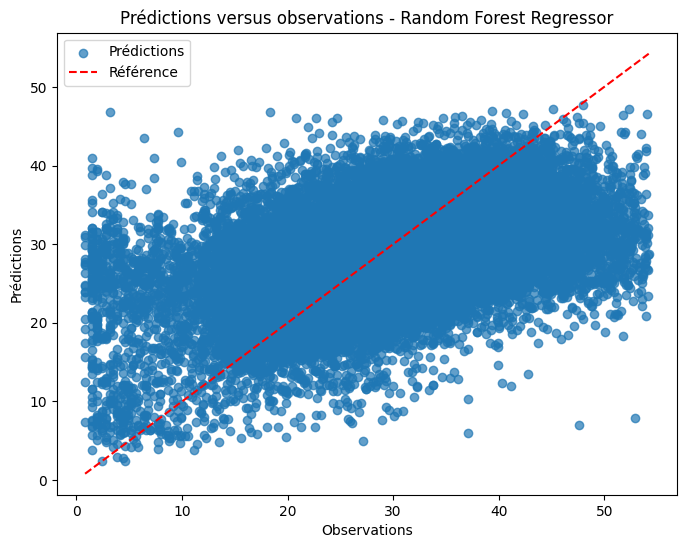

In [ ]:
plot_results(y_val, y_pred_RFR, "Random Forest Regressor");

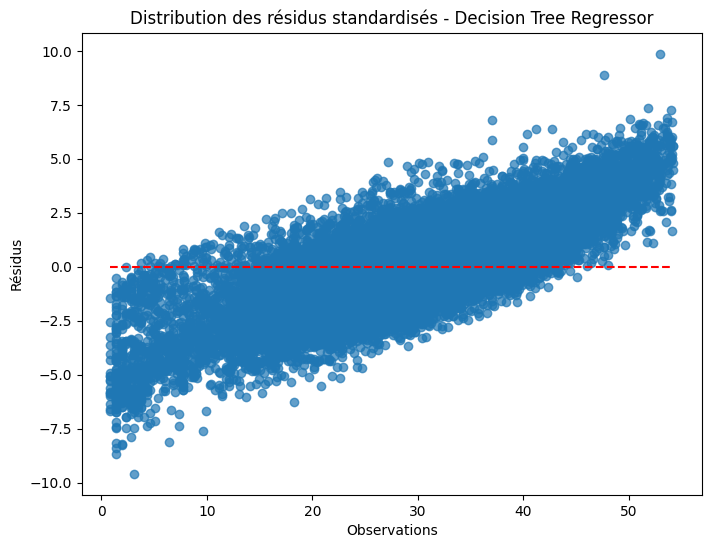

In [ ]:
# nota bene : pour que la méthode fonctionne, il faut modifier le format de y_pred_RFR

plot_residuals2(y_val, np.reshape(y_pred_RFR,(y_pred_RFR.shape[0],1)), "Random Forest Regressor");

Comme pour le modèle basé sur les arbres de décision, la distance est de loin la variable présentant le plus d'importance dans le modèle, suivi par la densité de casernes (`ratioStd`) puis la plage horaire 11-17 (`H1117`).

In [ ]:
feat_imp = pd.DataFrame({'importance': model.feature_importances_}, index=model.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,0.782009
ratioStd,0.030094
H1117,0.024849
Bor_inc_rep,0.011932
PropCat_Road Vehicle,0.010410
PropCat_Dwelling,0.010030
PropCat_Non Residential,0.008989
H26,0.008420
PropCat_Outdoor Structure,0.007358
PropCat_Outdoor,0.006503


### Recherche des hyper paramètres

Compte tenu du temps d'exécution de ce type de modèle, la recherche des hyper paramètres a été faite sur le jeu de données réduit.

In [ ]:
# Définition des hyperparamètres à explorer
rf_param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Modèle de base
rf_model = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_distributions,
    n_iter=50,  # Nombre d'échantillons aléatoires
    scoring='neg_mean_squared_error',  # Optimise MSE
    cv=3,  # Validation croisée à 3 splits
    verbose=2,
    random_state=42,
    n_jobs=-1  # Utilise tous les cœurs disponibles
)

# Ajustement du RandomizedSearchCV sur les données d'entraînement
rf_random_search.fit(X_train_r, y_train_r)

# Meilleurs hyperparamètres
print("Best parameters for Random Forest:", rf_random_search.best_params_)

# Évaluation avec les meilleurs hyperparamètres
best_rf_model = rf_random_search.best_estimator_
y_pred_BestRFR= train_and_evaluate_model(best_rf_model, "Optimized Random Forest Regressor", X_train_r, y_train_r, X_val_r, y_val_r)


# erreur lors de la fin de l'exécution (méthode non trouvée car non chargée)
# Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\ADUBOIS\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}


NameError: name 'train_and_evaluate_model' is not defined

Les cellules de code suivantes présente les résultats du regresseur Random Forest sur le jeux de données réduit en utilisant les hyper paramètres sélectionnés via le `RandomizedSearchCV`.


In [ ]:
# Évaluation avec les meilleurs hyperparamètres sur le jeu de données réduit
best_rf_model = rf_random_search.best_estimator_
y_pred_BestRFR= train_and_evaluate_model(best_rf_model, "Optimized Random Forest Regressor", X_train_r, y_train_r, X_val_r, y_val_r)



Optimized Random Forest Regressor
MSE (Validation): 18.2999
RMSE (Validation): 4.2778
MAE (Validation): 2.9067
MedAE (Validation): 2.0643
Max Error (Validation): 39.9589
R² (Validation): 0.4370


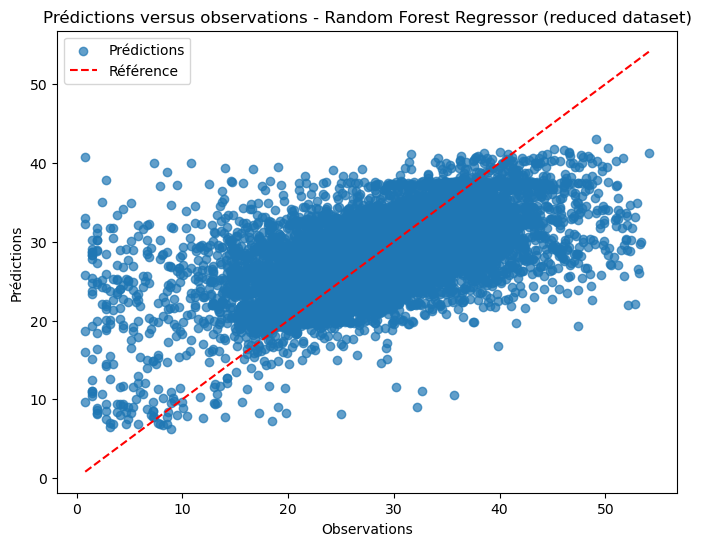

In [ ]:
plot_results(y_val_r, y_pred_BestRFR, "Random Forest Regressor (reduced dataset)");

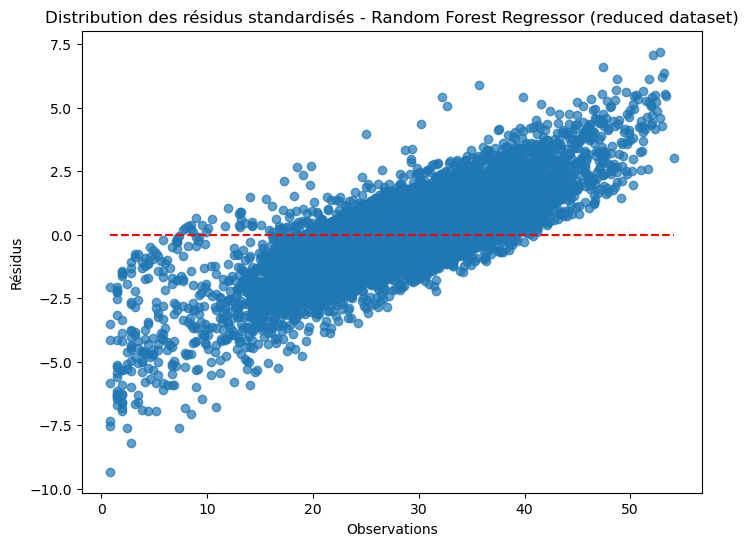

In [ ]:
plot_residuals2(y_val_r, np.reshape(y_pred_BestRFR,(y_pred_BestRFR.shape[0],1)), "Random Forest Regressor (reduced dataset)");

In [ ]:
feat_imp = pd.DataFrame({'importance': best_rf_model.feature_importances_}, index=best_rf_model.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,0.930242
H26,0.013126
ratioSC,0.008346
Stat_resp_rep,0.003841
Borough_E09000033,0.003731
Borough_E09000022,0.003423
PropCat_Outdoor,0.003210
PropCat_Non Residential,0.002676
PropCat_Dwelling,0.002434
Bor_inc_rep,0.002164


### Estimation finale

Il n'est pas possible de comparer les résultats obtenus sur le jeu de données réduit à ceux obtenus avec le jeu de données complet. Nous avons donc aussi fait un fit avec celui-ci.

In [ ]:
# Évaluation avec les meilleurs hyperparamètres sur le jeu de données total
best_rf_model = rf_random_search.best_estimator_
y_pred_BestRFR= train_and_evaluate_model(best_rf_model, "Optimized Random Forest Regressor", X_train, y_train, X_val, y_val)



Optimized Random Forest Regressor
MSE (Validation): 18.8421
RMSE (Validation): 4.3407
MAE (Validation): 2.9552
MedAE (Validation): 2.1172
Max Error (Validation): 39.0246
R² (Validation): 0.4182


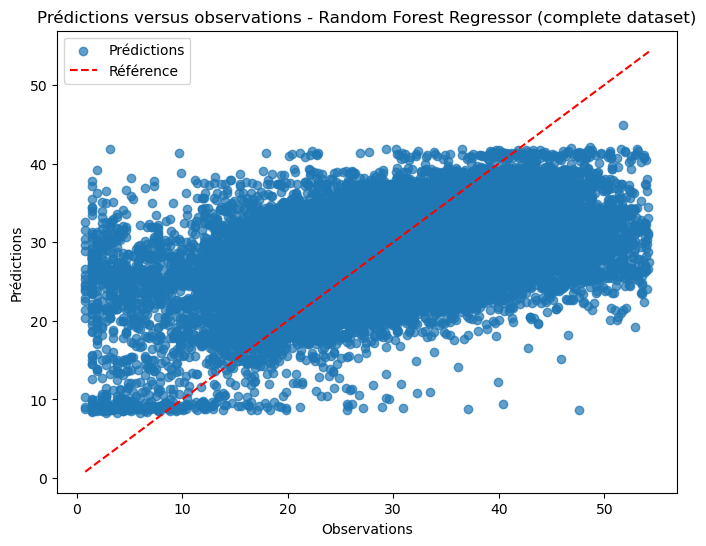

In [ ]:
plot_results(y_val, y_pred_BestRFR, "Random Forest Regressor (complete dataset)");

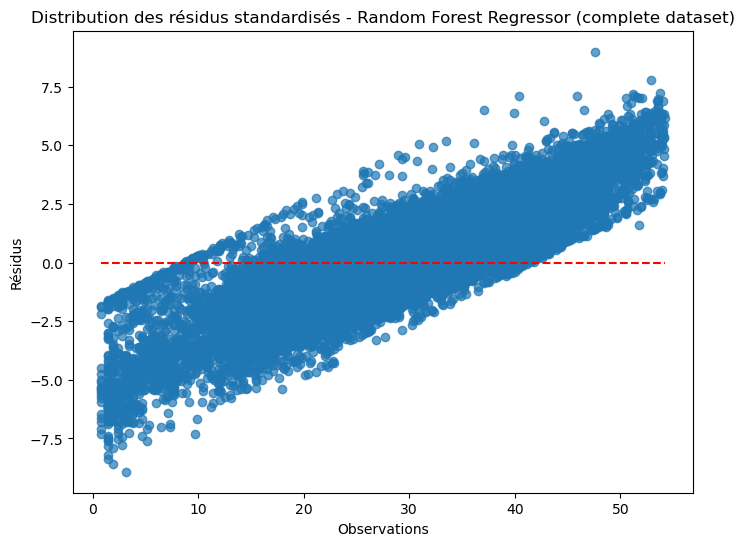

In [ ]:
plot_residuals2(y_val, np.reshape(y_pred_BestRFR,(y_pred_BestRFR.shape[0],1)), "Random Forest Regressor (complete dataset)");

Avec les hyper paramètres "optimisés", la distance est toujours la variable présentant le plus d'importance dans le modèle. Dans ce modèle, elle est suivie par la plage horaire 2-6 (`H26`) puis par la densité de casernes (`ratioStd`).

In [ ]:
feat_imp = pd.DataFrame({'importance': best_rf_model.feature_importances_}, index=best_rf_model.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,0.944965
H26,0.013269
ratioStd,0.005034
Stat_resp_rep,0.004927
Borough_E09000033,0.004679
PropCat_Outdoor,0.003553
Bor_inc_rep,0.002336
PropCat_Non Residential,0.002229
Borough_E09000022,0.002131
PropCat_Other Residential,0.001966


## <font color='blue'>3.c) XGB Regressor </font>

Nous avons testé le regresseur XGB qui utilise des méthodes de boosting pour optimiser le regresseur Decision Tree. XGBoost (Extreme Gradient Boosting) est une bibliothèque d'apprentissage automatique basée sur les arbres de décision et optimisée pour la vitesse et la performance. Elle utilise le gradient boosting avec des techniques avancées comme la régularisation (L1/L2), la gestion efficace des valeurs manquantes et le traitement parallèle, ce qui en fait un choix populaire pour les compétitions de datascience.


### Première estimation

In [ ]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_name = "XGBoost Regressor"
# Utilisation de la fonction train_and_evaluate_model
y_pred_XGR = train_and_evaluate_model(model_xgb, model_name, X_train, y_train, X_val, y_val)



XGBoost Regressor
MSE (Validation): 18.6878
RMSE (Validation): 4.3229
MAE (Validation): 2.9391
MedAE (Validation): 2.0996
Max Error (Validation): 38.2019
R² (Validation): 0.4229


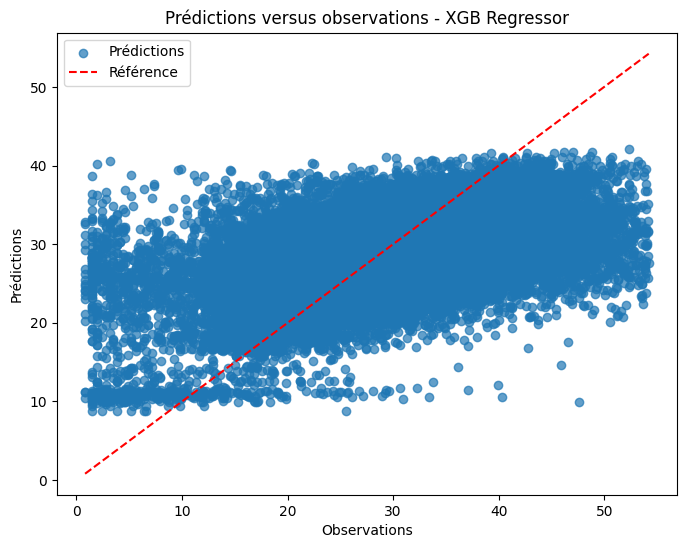

In [ ]:
plot_results(y_val, y_pred_XGR, "XGB Regressor");

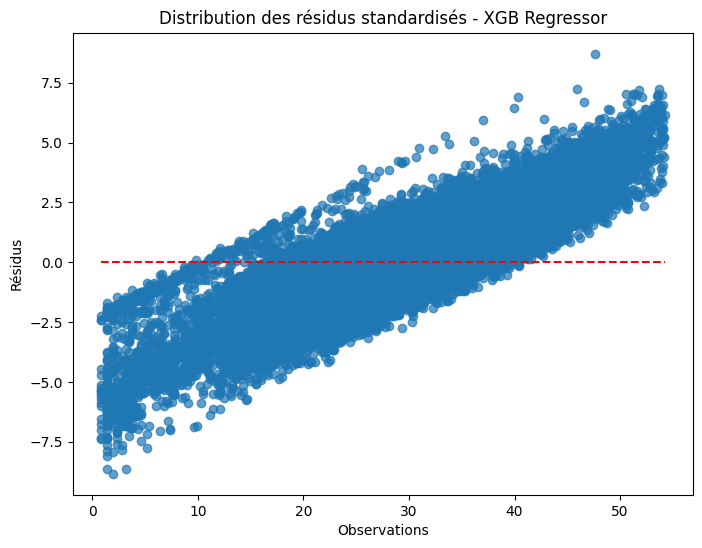

In [ ]:
plot_residuals2(y_val, np.reshape(y_pred_XGR,(y_pred_XGR.shape[0],1)), "XGB Regressor");

In [ ]:
feat_imp = pd.DataFrame({'importance': model_xgb.feature_importances_}, index=model_xgb.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,0.358373
H26,0.043344
Borough_E09000022,0.040154
Stat_resp_rep,0.038795
Borough_E09000033,0.029631
PropCat_Other Residential,0.024595
Borough_E09000009,0.021061
Borough_E09000010,0.020664
Borough_E09000005,0.020034
PropCat_Outdoor,0.019630


### Recherche des hyper paramètres

In [ ]:
xgb_param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.logspace(-3, 0, 10),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'gamma': np.linspace(0, 1, 5),
    'reg_alpha': np.logspace(-3, 1, 5),
    'reg_lambda': np.logspace(-3, 1, 5)
}

In [ ]:
# recherche fait sur le jeu de données réduit
xgb_model = XGBRegressor(random_state=42)
y_pred_xgb, best_params_xgb = find_best_params_and_predict(xgb_model, xgb_param_dist, X_train_r, y_train_r, X_val_r, y_val_r, "XGBoost")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

XGBoost - Best Parameters: {'subsample': 0.625, 'reg_lambda': 10.0, 'reg_alpha': 0.001, 'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.046415888336127774, 'gamma': 0.75, 'colsample_bytree': 0.875}
XGBoost - Best Cross-Validation Score: -18.2888

XGBoost
MSE (Validation): 18.0610
RMSE (Validation): 4.2498
MAE (Validation): 2.8737
MedAE (Validation): 2.0387
Max Error (Validation): 41.2678
R² (Validation): 0.4444


In [ ]:
# on applique le modèle avec les hyper paramètres sélectionnés au jeu de données complet
xgb_model = XGBRegressor(random_state=42, subsample = 0.625, reg_lambda = 10.0, reg_alpha = 0.001, n_estimators = 250
                         , max_depth= 9, learning_rate = 0.04641589, gamma = 0.75, colsample_bytree = 0.875)
model_name = "XGBoost Regressor"
y_pred_XG = train_and_evaluate_model(xgb_model, model_name, X_train, y_train, X_val, y_val)


XGBoost Regressor
MSE (Validation): 18.5136
RMSE (Validation): 4.3027
MAE (Validation): 2.9125
MedAE (Validation): 2.0640
Max Error (Validation): 39.3001
R² (Validation): 0.4283


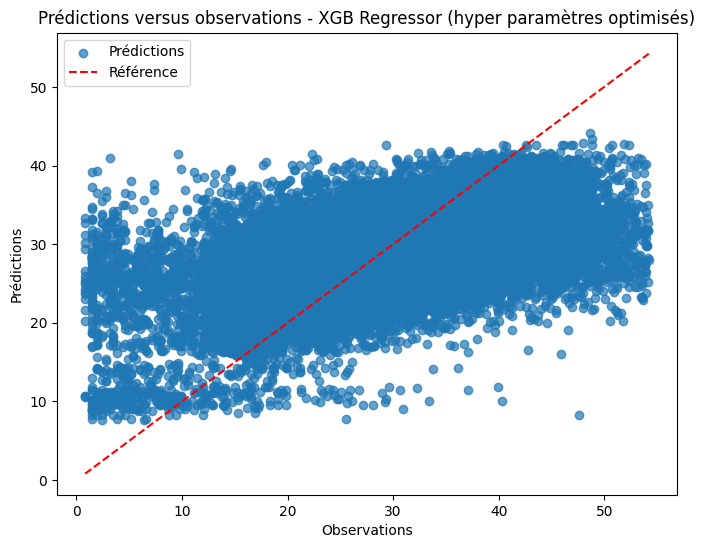

In [ ]:
plot_results(y_val, y_pred_XG, "XGB Regressor (hyper paramètres optimisés)");

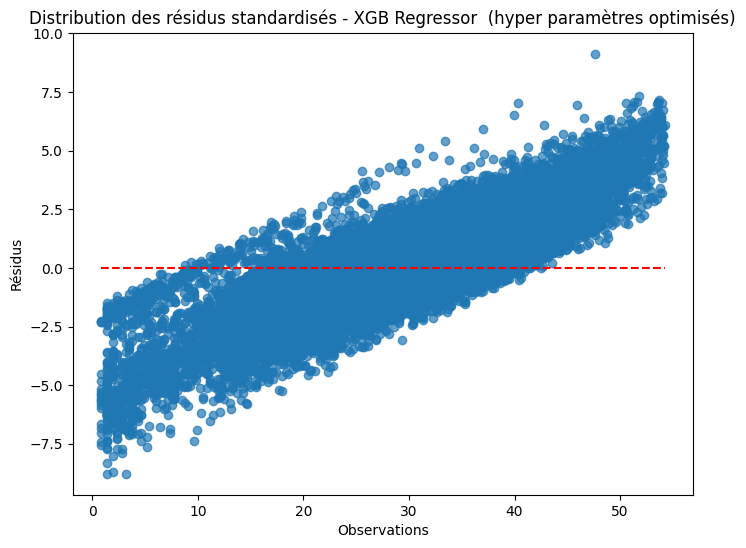

In [ ]:
plot_residuals2(y_val, np.reshape(y_pred_XG,(y_pred_XG.shape[0],1)), "XGB Regressor  (hyper paramètres optimisés)");

In [ ]:
feat_imp = pd.DataFrame({'importance': xgb_model.feature_importances_}, index=xgb_model.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,0.152072
inner,0.144231
Stat_resp_rep,0.125373
Borough_E09000033,0.030031
Borough_E09000022,0.026866
ratioStd,0.025982
H26,0.021206
Borough_E09000031,0.017599
Borough_E09000020,0.017047
Borough_E09000014,0.016495


## <font color='blue'>3.d) LGBM Regressor </font>

LightGBM (Light Gradient Boosting Machine) est une alternative à XGBoost, développée par Microsoft, qui se distingue par son efficacité et sa rapidité. Contrairement à XGBoost, il utilise une approche leaf-wise au lieu de level-wise, ce qui permet d'accélérer l'entraînement tout en maintenant une grande précision, notamment sur les grands ensembles de données.


### Première estimation

In [ ]:
model_lgbm = LGBMRegressor(random_state=42)
model_name = "LGBM Regressor"
# Utilisation de la fonction train_and_evaluate_model
y_pred_GLBM = train_and_evaluate_model(model_lgbm, model_name, X_train, y_train, X_val, y_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 726399, number of used features: 50
[LightGBM] [Info] Start training from score 27.860041

LGBM Regressor
MSE (Validation): 18.6831
RMSE (Validation): 4.3224
MAE (Validation): 2.9383
MedAE (Validation): 2.1010
Max Error (Validation): 38.3243
R² (Validation): 0.4231


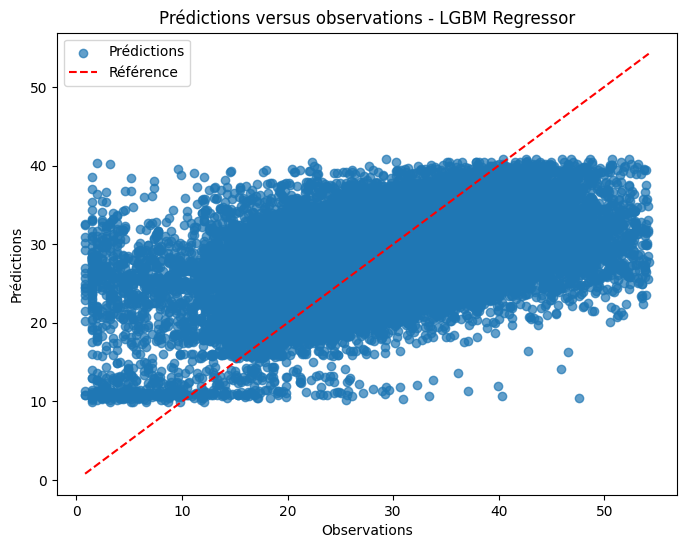

In [ ]:
plot_results(y_val, y_pred_GLBM, "LGBM Regressor");

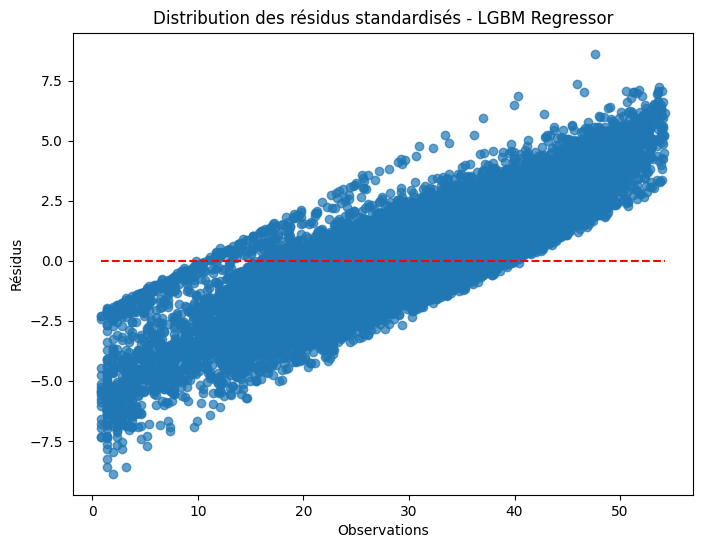

In [ ]:
plot_residuals2(y_val, np.reshape(y_pred_GLBM,(y_pred_GLBM.shape[0],1)), "LGBM Regressor");

In [ ]:
feat_imp = pd.DataFrame({'importance': model_lgbm.feature_importances_}, index=model_lgbm.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
distStd,1077
Bor_inc_rep,170
ratioStd,146
H26,141
Stat_resp_rep,107
PropCat_Non_Residential,100
Borough_E09000033,100
PropCat_Dwelling,95
PropCat_Outdoor,90
PropCat_Other_Residential,82


### Recherche des hyper paramètres

In [ ]:
lgbm_param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.logspace(-3, 0, 10),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-3, 1, 5),
    'reg_lambda': np.logspace(-3, 1, 5),
    'num_leaves': np.arange(20, 150, 10)
}

In [ ]:
lgbm_model = LGBMRegressor(objective='regression', random_state=42)
y_pred_lgbm, best_params_lgbm = find_best_params_and_predict(lgbm_model, lgbm_param_dist, X_train, y_train, X_val, y_val, "LightGBM")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 726399, number of used features: 50
[LightGBM] [Info] Start training from score 27.860041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
lgb_model = XGBRegressor(random_state=42, subsample = 0.75, reg_lambda = 1.0, reg_alpha = 10, num_leaves= 120, n_estimators = 250
                         , max_depth= 7, learning_rate = 0.215443469, colsample_bytree = 0.75)
model_name = "LGBM Regressor"
y_pred_LGB = train_and_evaluate_model(lgb_model, model_name, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[11:41:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "num_leaves" } are not used.





LGBM Regressor
MSE (Validation): 18.5330
RMSE (Validation): 4.3050
MAE (Validation): 2.9116
MedAE (Validation): 2.0616
Max Error (Validation): 40.1569
R² (Validation): 0.4277


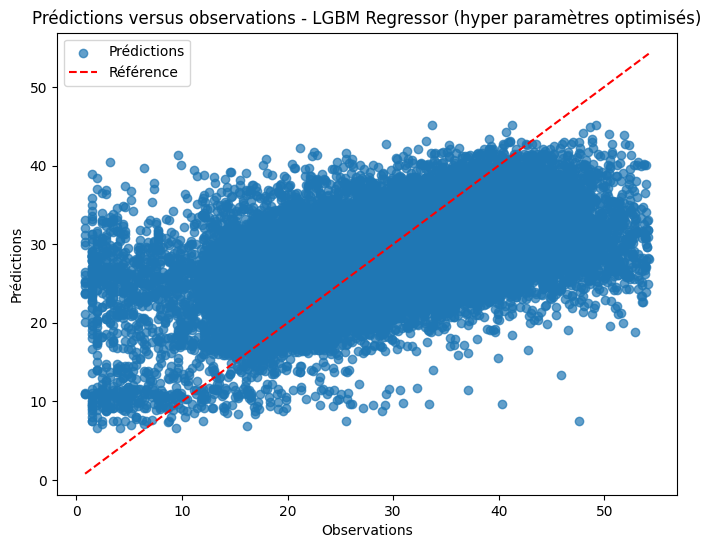

In [ ]:
plot_results(y_val, y_pred_LGB, "LGBM Regressor (hyper paramètres optimisés)");

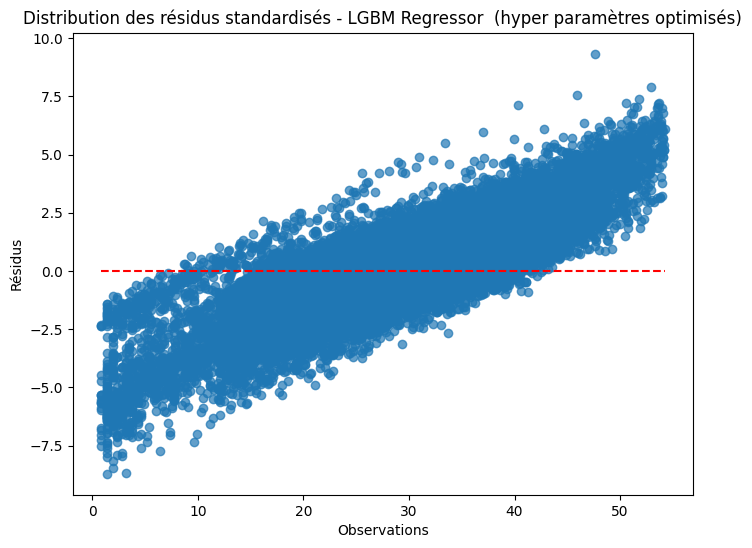

In [ ]:
plot_residuals2(y_val, np.reshape(y_pred_LGB,(y_pred_LGB.shape[0],1)), "LGBM Regressor  (hyper paramètres optimisés)");

In [ ]:
feat_imp = pd.DataFrame({'importance': lgb_model.feature_importances_}, index=lgb_model.feature_names_in_)
feat_imp.sort_values(by=['importance'], ascending=False).head(10)

,importance
Stat_resp_rep,0.199619
inner,0.189188
distStd,0.124046
ratioStd,0.033116
Borough_E09000033,0.028332
Borough_E09000022,0.022772
H26,0.018423
Borough_E09000031,0.016718
Borough_E09000017,0.015053
Borough_E09000008,0.014670


# <font color='red'> 6) Conclusion
 </font>


Le tableau ci-dessous résume les résultats de modélisation de ce notebook. Le R² est renseigné uniquement pour les modèles linéaires. Comme déjà discuté, quelque soit le modèle linéaire, la valeur de R² est faible, indiquant une mauvais fit du modèle. Le modèle avec les erreurs les plus faibles est le régresseur XGB. Cependant, ce modèle n'est pas satisfaisant car les prédictions sont mauvaises, comme le montre le graphique des prédictions versus observations.

</br></br>



<table>
<tr>
<th>Modèle</th>
<th>R²</th>
<th>MSE</th>
<th>RMSE</th>
<th>MAE</th>
<th>MedAE</th>
<th>Max Error</th>
</tr>
<tr>
<td>Régression Linéaire</td>
<td> 0.2462</td>
<td> 24.41</td>
<td> 4.941</td>
<td> 3.525</td>
<td> 2.622</td>
<td> 36.66</td>
</tr>

<td>Modèle de Ridge</td>
<td> 0.2462</td>
<td> 24.41</td>
<td> 4.941</td>
<td> 3.525</td>
<td> 2.622</td>
<td> 36.66</td>
</tr>

<td>Modèle de Lasso</td>
<td> 0.2458</td>
<td> 24.42</td>
<td> 4.942</td>
<td> 3.525</td>
<td> 2.622</td>
<td> 36.55</td>
</tr>

<td>Modèle Elastic Net</td>
<td> 0.2461</td>
<td> 24.41</td>
<td> 4.941</td>
<td> 3.525</td>
<td> 2.622</td>
<td> 36.63</td>
</tr>

<td>Decision Tree Regressor</td>
<td> /</td>
<td> 31.58</td>
<td> 5.620</td>
<td> 3.780</td>
<td> 2.481</td>
<td> 51.48</td>
</tr>

<td>Random Forest Regressor</td>
<td> /</td>
<td> 18.84</td>
<td> 4.341</td>
<td> 2.956</td>
<td> 2.117</td>
<td> 39.02</td>
</tr>

<td>XGB Regressor</td>
<td> /</td>
<td> 18.51</td>
<td> 4.303</td>
<td> 2.912</td>
<td> 2.064</td>
<td> 39.30</td>
</tr>

<td>LGBM Regressor</td>
<td> /</td>
<td> 18.53</td>
<td>4.305</td>
<td>2.912 </td>
<td> 2.062</td>
<td> 40.16</td>
</tr>

</table>

Il est intéressant de noter que la distance (`distStd`) et la densité de caserne (`ratioStd`) sont toujours des variables explicatives importantes, quelque soit le modèle testé. Les variables binaires `Stat_resp_rep` et `H26` semblent aussi êtres importantes.

Dans le prochain notebook, nous modélisons le temps après catégorisation en 10 (`ResponseTimeCategory`). Pour cela, nous allons utiliser des méthodes de classification.